
# **Calculating WMD and Cosine Score for JSTOR Labeled Articles**



Computational Literature Review

Creator: Nancy Xu

Date created: September 6, 2022

Date last modified: October 28, 2022

This notebook:

- calculates Word Mover's Distance (using a gensim Word2Vec model) between an article and core seed terms
- calculates cosine similarity between an article (represented by average of Word2Vec embeddings of its tokens) and average vector of core seed terms (represented by a Word2Vec embedding)
- compares the distribution of WMD scores and cosine similarity scores for each positive/negative perspective

Files used:
- labeled data
    - /home/jovyan/work/models_storage/preprocessed_texts/training_relational_preprocessed_100321.pkl
    - /home/jovyan/work/models_storage/preprocessed_texts/training_demographic_preprocessed_100321.pkl
    - /home/jovyan/work/models_storage/preprocessed_texts/training_cultural_preprocessed_100321.pkl
- seed terms:
    - demographic_core.txt
    - relational_core.txt
    - cultural_core.txt
    
- word2vec phased model
    - models_storage/tree/master/w2v_models/word2vec_phrased_filtered_300d_2020_sept5.bin

In [4]:
import pandas as pd
import gensim
import pickle
import os
import re
import ast
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from sklearn import utils
cores = multiprocessing.cpu_count()
import gensim
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from numpy import dot, absolute
from numpy.linalg import norm

## Text preprocessing 

Load in and preprocess dataframes for each perspective.

In [2]:
# os.chdir('/home/jovyan/work/models_storage/preprocessed_texts')
def open_test_data(path):
    return open(path, 'rb')
with open_test_data('/home/jovyan/work/models_storage/preprocessed_texts/training_relational_preprocessed_100321.pkl') as f:
    rela = pickle.load(f)

with open_test_data('/home/jovyan/work/models_storage/preprocessed_texts/training_demographic_preprocessed_100321.pkl') as f:
    demog = pickle.load(f)

with open_test_data('/home/jovyan/work/models_storage/preprocessed_texts/training_cultural_preprocessed_100321.pkl') as f:
    cult = pickle.load(f)
    

import itertools
full_text = []

for i in cult['text']:
    joined = list(itertools.chain(*i))
    full_text.append(" ".join(joined))

full_text_demog = []
for i in demog['text']:
    joined = list(itertools.chain(*i))
    full_text_demog.append(" ".join(joined))

full_text_rela = []
for j in rela['text']:
    joined = list(itertools.chain(*j))
    full_text_rela.append(" ".join(joined))

cult['full_text'] = full_text
demog['full_text'] = full_text_demog
# orgs['full_text'] = full_text_orgs
rela['full_text'] = full_text_rela

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nancyxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


remove html tags

In [ ]:
def remove_tags(article):
    article = re.sub('<plain_text> <page sequence="1">', '', article)
    article = re.sub(r'</page>(\<.*?\>)', ' \n ', article)
    # xml tags
    article = re.sub(r'<.*?>', '', article)
    article = re.sub(r'<body.*\n\s*.*\s*.*>', '', article)
    return article

tags_removed = [remove_tags(art) for art in cult['full_text']]
tags_removed_demog = [remove_tags(art) for art in demog['full_text']]
# tags_removed_org = [remove_tags(art) for art in orgs['full_text']]
tags_removed_rela = [remove_tags(art) for art in rela['full_text']]
cult['text_no_tags'] = tags_removed
demog['text_no_tags'] = tags_removed_demog
# orgs['text_no_tags'] = tags_removed_org
rela['text_no_tags'] = tags_removed_rela


preporcess the text to remove stop words, punctuations

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['one', 'two', 'three', 'amp', 'may', 'can', 'new', 'also', 'and'])

import string
import re
import nltk

def word_process(tt):
    """
    helper function to lower text, remove stop words, numbers, and empty 
    """
    
    tt = tt.lower()
    
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~=\n'''
    # Removing punctuations in string 
    # Using loop + punctuation string 


    for ele in tt:  
        if ele in punc:  
            tt = tt.replace(ele, " ")  

    # read tokens
    tokens = tt.split()
    lst = [token.translate(punc).lower() for token in tokens ]
    
    #remove stop words
    filtered = []
    for i in lst:
        if i not in stop_words:
            filtered.append(i)
    
    # removing singular numbers and singular letters
    pattern = '[0-9]'
    filtered = [re.sub(pattern, '', i) for i in filtered] 
    new = []
    for inp in filtered:
        new.append(' '.join( [w for w in inp.split() if len(w)>1] ))
        
    # filter out empty strings 
    new = [i for i in new if i] 

    dt = [d.split() for d in new]
    
  
    st = ''
    for i in dt:
        st = st + " " + i[0]
    return st
    

In [ ]:
cult['processed']  =  cult['text_no_tags'].apply(word_process)
rela['processed']  =  rela['text_no_tags'].apply(word_process)
demog['processed']  =  demog['text_no_tags'].apply(word_process)

cult_pos = cult[cult['cultural_score']==1]
cult_neg = cult[cult['cultural_score']==0]

rela_pos = rela[rela['relational_score']==1]
rela_neg = rela[rela['relational_score']==0]

demog_pos = demog[demog['demographic_score']==1]
demog_neg = demog[demog['demographic_score']==0]


In [27]:
pos_cult = cult[cult['cultural_score']==1].reset_index()
neg_cult = cult[cult['cultural_score']==0].reset_index()

pos_rela = rela[rela['relational_score']==1].reset_index()
neg_rela = rela[rela['relational_score']==0].reset_index()

pos_demog = demog[demog['demographic_score']==1].reset_index()
neg_demog = demog[demog['demographic_score']==0].reset_index()


In [22]:
cult_pos.to_csv('cult_pos_full.csv')
cult_neg.to_csv('cult_neg_full.csv')

In [24]:
rela_pos.to_csv('rela_pos_full.csv')
rela_neg.to_csv('rela_neg_full.csv')

In [25]:
demog_pos.to_csv('demog_pos_full.csv')
demog_neg.to_csv('demog_neg_full.csv')

load in pretrained phrased w2v model

In [3]:
w2v=Word2Vec.load('word2vec_phrased_filtered_300d_2020_sept5.bin')

## Compute WMD between an article and perspective seed terms

reference: https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html

In [28]:
def calc_wmd(a,b):
    return w2v.wmdistance(a,b)

In [31]:
def read_txt_lst(file):
    txt_file = open(file, "r")
    file_content = txt_file.read()
    # print("The file content are: ", file_content)

    content_list = file_content.split("\n")
    txt_file.close()
    return content_list

In [32]:
dem_core=read_txt_lst('demographic_core.txt')
rela_core=read_txt_lst('relational_core.txt')
cult_core = read_txt_lst('cultural_core.txt')

In [33]:
dem_core=[re.sub(r'\s','_',x) for x in dem_core]
rela_core=[re.sub(r'\s','_',x) for x in rela_core]
cult_core=[re.sub(r'\s','_',x) for x in cult_core]

In [32]:
from nltk.tokenize import word_tokenize

In [33]:
def get_sims_with_perspective(article):
  """
  get wmd similarity between this article and the core terms of each perspective
  """

  ## first build bigram from the article

  article_tokens = article.split()

#   article_tokens = word_tokenize(article)
    
  dem_score = calc_wmd(article_tokens,(dem_core))
  rela_score = calc_wmd(article_tokens,(rela_core))
  cult_score = calc_wmd(article_tokens,(cult_core))
  return (dem_score,rela_score,cult_score)

In [37]:
get_sims_with_perspective(cult_pos.loc[0,'processed'])

/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_50075/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)


(4.295224225608303, 4.103406504450474, 4.014661249573525)

In [34]:
from tqdm import tqdm
tqdm.pandas()

def get_sim_perspective(df):

    """
    returns modified df with extra columns dem_score,rela_score,cult_score
    denoting the wmd score calculated for each article.
    """
    tqdm.pandas()

    results=df['processed'].progress_apply(lambda x:get_sims_with_perspective(x))
    dem_scores = [i[0] for i in results]
    rela_scores = [i[1] for i in results]
    cult_scores = [i[2] for i in results]
    df['dem_scores'] = dem_scores
    df['rela_scores'] = rela_scores
    df['cult_scores']= cult_scores
    return df

In [37]:
pos_cult = get_sim_perspective(cult_pos)
neg_cult = get_sim_perspective(cult_neg)

  0%|                                                   | 0/234 [00:00<?, ?it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
  0%|                                                   | 0/475 [00:00<?, ?it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
100%|███████████████████████████████████████| 475/475 [2:32:28<00:00, 19.26s/it]


In [ ]:
pos_cult.to_csv('pos_cult_full_scores.csv')
neg_cult.to_csv('neg_cult_full_scores.csv')

In [ ]:
pos_demog = get_sim_perspective(demog_pos)
neg_demog = get_sim_perspective(demog_neg)


  0%|                                                   | 0/256 [00:00<?, ?it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
  0%|                                           | 1/477 [00:00<00:51,  9.31it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
100%|███████████████████████████████████████| 477/477 [2:47:09<00:00, 21.03s/it]


In [ ]:
pos_demog.to_csv('pos_demog_full_scores.csv')
neg_demog.to_csv('neg_demog_full_scores.csv')

In [ ]:

pos_rela = get_sim_perspective(rela_pos)
neg_rela = get_sim_perspective(rela_neg)

  0%|▏                                          | 1/287 [00:00<00:31,  9.21it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
  0%|                                                   | 0/420 [00:00<?, ?it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
 23%|█████████▏                              | 97/420 [39:02<1:11:08, 13.22s/it]

In [ ]:
pos_rela.to_csv('pos_rela_full_scores.csv')
neg_rela.to_csv('neg_rela_full_scores.csv')

In [110]:
pos_demog = pd.read_csv('pos_demog_full_scores.csv')
neg_demog= pd.read_csv('neg_demog_full_scores.csv')
pos_cult = pd.read_csv('pos_cult_full_scores.csv')
neg_cult= pd.read_csv('neg_cult_full_scores.csv')
pos_rela = pd.read_csv('pos_rela_full_scores.csv')
neg_rela= pd.read_csv('neg_rela_full_scores.csv')

In [111]:
pos_cult=pos_cult.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})
neg_cult=neg_cult.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})

pos_demog=pos_demog.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})
neg_demog=neg_demog.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})

pos_rela=pos_rela.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})
neg_rela=neg_rela.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})

## Calculate cosine similarity score between the article and each perspective

Using Word2Vec to get vector representations of the text in each jstor article, average them to get the article embedding, then calculate cosine similarity between the embedding of each article and average w2v vector for each perspective.

reference: https://github.com/h2researchgroup/embeddings/blob/main/preprocessing/cosine_values_calculate_word2vec.py

In [34]:
cult_core_embs=[]
for x in cult_core:
  try:
    cult_core_embs.append(w2v.wv[x])
  except:
    pass


In [35]:
demog_core_embs=[]
for x in dem_core:
  try:
    demog_core_embs.append(w2v.wv[x])
  except:
    pass


In [36]:
rela_core_embs=[]
for x in rela_core:
  try:
    rela_core_embs.append(w2v.wv[x])
  except:
    pass


In [112]:
import numpy as np
rela_core_embs_mean = np.mean(rela_core_embs, axis=0)
cult_core_embs_mean = np.mean(cult_core_embs, axis=0)
demog_core_embs_mean = np.mean(demog_core_embs, axis=0)

In [113]:
def doc_words_cosine(doc):
    """
  doc = str of text
  get cosine similarity scores between the document embedding and average emb of the core terms in each perspective.
  """
#     ss = [doc.split()]
#     bb = build_phrases(ss)
#     pb = [bb[i] for i in ss][0]
    tokens = doc.split()
    article_embs=[]
    for k in tokens:
      try:
        article_embs.append(w2v.wv[k])
      except:
        pass
    doc_vec = np.mean(np.array(article_embs), axis=0)
    cult_sim = absolute(dot(doc_vec, cult_core_embs_mean)/(norm(doc_vec)*norm(cult_core_embs_mean)))
    rela_sim = absolute(dot(doc_vec, rela_core_embs_mean)/(norm(doc_vec)*norm(rela_core_embs_mean)))
    demog_sim = absolute(dot(doc_vec, demog_core_embs_mean)/(norm(doc_vec)*norm(demog_core_embs_mean)))
    return (demog_sim,rela_sim,cult_sim)

In [114]:
def apply_doc_words_cosine(df):

  """
  applies doc_words_cosine on the processed texts in each df
  returns modified df with new columns dem_sim,rela_sim,cult_sim
  """

  results=df['processed'].apply(lambda x:doc_words_cosine(x))
  dem_scores = [i[0] for i in results]
  rela_scores = [i[1] for i in results]
  cult_scores = [i[2] for i in results]
  df['dem_sim'] = dem_scores
  df['rela_sim'] = rela_scores
  df['cult_sim']= cult_scores

  return df

In [115]:
pos_cult = apply_doc_words_cosine(pos_cult)
neg_cult = apply_doc_words_cosine(neg_cult)

pos_demog = apply_doc_words_cosine(pos_demog)
neg_demog = apply_doc_words_cosine(neg_demog)

pos_rela = apply_doc_words_cosine(pos_rela)
neg_rela = apply_doc_words_cosine(neg_rela)

To classify an article with WMD, get the perspective with the smallest distance.

In [117]:
pos_rela['classified_perspective_wmd']=pos_rela.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
neg_rela['classified_perspective_wmd']=neg_rela.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
pos_cult['classified_perspective_wmd']=pos_cult.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
neg_cult['classified_perspective_wmd']=neg_cult.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
pos_demog['classified_perspective_wmd']=pos_demog.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
neg_demog['classified_perspective_wmd']=neg_demog.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)

In [118]:
perspective_dict={0:'demographic', 1:'relational', 2:'cultural'}

In [119]:
pos_rela['classified_perspective_wmd'] = pos_rela['classified_perspective_wmd'].replace(perspective_dict)
neg_rela['classified_perspective_wmd'] = neg_rela['classified_perspective_wmd'].replace(perspective_dict)
pos_cult['classified_perspective_wmd'] = pos_cult['classified_perspective_wmd'].replace(perspective_dict)
neg_cult['classified_perspective_wmd'] = neg_cult['classified_perspective_wmd'].replace(perspective_dict)
pos_demog['classified_perspective_wmd'] = pos_demog['classified_perspective_wmd'].replace(perspective_dict)
neg_demog['classified_perspective_wmd'] = neg_demog['classified_perspective_wmd'].replace(perspective_dict)

To classify an article with cosine similarity, get the perspective with the biggest cosine similarity.

In [120]:
pos_rela['classified_perspective_cos']=pos_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_rela['classified_perspective_cos']=neg_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_cult['classified_perspective_cos']=pos_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_cult['classified_perspective_cos']=neg_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_demog['classified_perspective_cos']=pos_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_demog['classified_perspective_cos']=neg_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)

In [121]:
pos_rela['classified_perspective_cos'] = pos_rela['classified_perspective_cos'].replace(perspective_dict)
neg_rela['classified_perspective_cos'] = neg_rela['classified_perspective_cos'].replace(perspective_dict)
pos_cult['classified_perspective_cos'] = pos_cult['classified_perspective_cos'].replace(perspective_dict)
neg_cult['classified_perspective_cos'] = neg_cult['classified_perspective_cos'].replace(perspective_dict)
pos_demog['classified_perspective_cos'] = pos_demog['classified_perspective_cos'].replace(perspective_dict)
neg_demog['classified_perspective_cos'] = neg_demog['classified_perspective_cos'].replace(perspective_dict)

In [122]:
pos_cult=pos_cult.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})
neg_cult=neg_cult.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})

pos_demog=pos_demog.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})
neg_demog=neg_demog.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})

pos_rela=pos_rela.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})
neg_rela=neg_rela.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})

In [125]:
neg_cult

,Unnamed: 0,index,text,cultural_score,primary_subject,edited_filename,article_name,full_text,text_no_tags,processed,dem_wmd,rela_wmd,cult_wmd,dem_cos_sim,rela_cos_sim,cult_cos_sim,classified_perspective_wmd,classified_perspective_cos
0,0,0,"[['Where', 'Do', 'Interorganizational', 'Netwo...",0.0,Sociology,10.1086_210179,Where Do Interorganizational Networks Come From?,Where Do Interorganizational Networks Come Fro...,Where Do Interorganizational Networks Come Fro...,interorganizational networks come ranjay gula...,4.133519,3.791740,3.921651,0.654313,0.782101,0.640492,relational,relational
1,1,2,"[['Between', 'Markets', 'and', 'Politics:', 'O...",0.0,Sociology,10.1086_231084,Between Markets and Politics: Organizational R...,Between Markets and Politics: Organizational R...,Between Markets and Politics: Organizational R...,markets politics organizational responses ref...,4.135670,3.896682,3.882817,0.619164,0.703068,0.625492,cultural,relational
2,2,7,"[['<body', 'xmlns:xlink=""http://www..org//xlin...",0.0,Sociology,10.1086_657524,Corporate Unity in American Trade Policy: A Ne...,"<body xmlns:xlink=""http://www..org//xlink"" xml...",Introduction The rise of neoliberal trade pol...,introduction rise neoliberal trade policy emb...,4.245731,3.870278,3.982369,0.599793,0.777399,0.632189,relational,relational
3,3,9,"[['Science,', 'Health,', 'and', 'Nationhood', ...",0.0,Sociology,10.1525_irqr.2011.4.3.199,"Science, Health, and Nationhood","Science, Health, and Nationhood Methodological...","Science, Health, and Nationhood Methodological...",science health nationhood methodological path...,4.213399,4.067452,3.831603,0.561955,0.580864,0.700933,cultural,cultural
4,4,10,"[['Negotiated', 'Orders:', 'The', 'Negotiation...",0.0,Sociology,10.1525_si.1994.17.2.165,Negotiated Orders: The Negotiation of Directiv...,Negotiated Orders: The Negotiation of Directiv...,Negotiated Orders: The Negotiation of Directiv...,negotiated orders negotiation directives para...,4.492472,4.330858,4.210306,0.486194,0.539144,0.556231,cultural,cultural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,470,621,"[['gmibrown.qxd', 'Page', 'The', 'Meta-trend',...",0.0,Management & Organizational Behavior,10.2307_greemanainte.54.53,The Meta-trend Stakeholder Profile: Impacts on...,gmibrown.qxd Page The Meta-trend Stakeholder P...,gmibrown.qxd Page The Meta-trend Stakeholder P...,gmibrown qxd page meta trend stakeholder prof...,4.278088,4.086866,4.069789,0.590667,0.677445,0.573609,cultural,relational
471,471,623,"[['jcc.waddock', 'pm', 'Page', 'Learning', 'fr...",0.0,Management & Organizational Behavior,10.2307_jcorpciti.11.51,Learning from Experience: The United Nations G...,jcc.waddock pm Page Learning from Experience T...,jcc.waddock pm Page Learning from Experience T...,jcc waddock pm page learning experience unite...,4.183009,3.956744,3.857287,0.578491,0.670543,0.657430,cultural,relational
472,472,625,"[['jccstevulak.qxd', 'Page', 'Supply-Side', 'C...",0.0,Management & Organizational Behavior,10.2307_jcorpciti.29.33,Supply-Side Corruption: Perspectives on a Tril...,jccstevulak.qxd Page Supply-Side Corruption Pe...,jccstevulak.qxd Page Supply-Side Corruption Pe...,jccstevulak qxd page supply side corruption p...,4.303510,4.048736,3.987552,0.523482,0.648969,0.617711,cultural,relational
473,473,626,"[['jccmason.qxd', 'Page', 'Post-traditional', ...",0.0,Management & Organizational Behavior,10.2307_jcorpciti.31.31,Post-traditional Corporate Governance,jccmason.qxd Page Post-traditional Corporate G...,jccmason.qxd Page Post-traditional Corporate G...,jccmason qxd page post traditional corporate ...,4.210057,3.927020,3.875391,0.586157,0.714379,0.691034,cultural,relational


In [126]:
from sklearn.preprocessing import normalize
def normalize_invert_wmd(df):
    """
    normalize the wmd, then invert it (1- normalized wmd),
    also normalize cosine simiarlity score.
    
    """
    dem_wmd=df.dem_wmd
    rela_wmd=df.rela_wmd
    cult_wmd=df.cult_wmd
    
    dem_cos = df.dem_cos_sim
    rela_cos = df.rela_cos_sim
    cult_cos = df.cult_cos_sim
    
    normalized_dem_wmd,normalized_rela_wmd,normalized_cult_wmd = [],[],[]
    normalized_dem_cos,normalized_rela_cos,normalized_cult_cos = [],[],[]
    
    for i in np.arange(len(df)):
      
        normalized_inverted_3_scores_wmd = 1 - normalize([[dem_wmd[i],rela_wmd[i], cult_wmd[i]]])
#         print(normalized_inverted_3_scores)
        normalized_dem_wmd.append(normalized_inverted_3_scores_wmd[0][0])
        normalized_rela_wmd.append(normalized_inverted_3_scores_wmd[0][1])
        normalized_cult_wmd.append(normalized_inverted_3_scores_wmd[0][2])
        
  
        normalized_inverted_3_scores_cos = normalize([[dem_cos[i],rela_cos[i], cult_cos[i]]])
        
        normalized_dem_cos.append(normalized_inverted_3_scores_cos[0][0])
        normalized_rela_cos.append(normalized_inverted_3_scores_cos[0][1])
        normalized_cult_cos.append(normalized_inverted_3_scores_cos[0][2])
        
    df['normalized_dem_wmd']=normalized_dem_wmd
    df['normalized_rela_wmd']=normalized_rela_wmd
    df['normalized_cult_wmd']=normalized_cult_wmd
    
    df['normalized_dem_cos']=normalized_dem_cos
    df['normalized_rela_cos']=normalized_rela_cos
    df['normalized_cult_cos']=normalized_cult_cos
    
    return df
        

In [127]:
pos_cult = normalize_invert_wmd(pos_cult.reset_index())
neg_cult = normalize_invert_wmd(neg_cult.reset_index())

pos_demog = normalize_invert_wmd(pos_demog.reset_index())
neg_demog = normalize_invert_wmd(neg_demog.reset_index())

pos_rela = normalize_invert_wmd(pos_rela)
neg_rela = normalize_invert_wmd(neg_rela)

In [128]:
pos_rela

,Unnamed: 0,index,text,relational_score,primary_subject,edited_filename,article_name,full_text,text_no_tags,processed,...,rela_cos_sim,cult_cos_sim,classified_perspective_wmd,classified_perspective_cos,normalized_dem_wmd,normalized_rela_wmd,normalized_cult_wmd,normalized_dem_cos,normalized_rela_cos,normalized_cult_cos
0,0,0,"[['Where', 'Do', 'Interorganizational', 'Netwo...",1.0,Sociology,10.1086_210179,Where Do Interorganizational Networks Come From?,Where Do Interorganizational Networks Come Fro...,Where Do Interorganizational Networks Come Fro...,interorganizational networks come ranjay gula...,...,0.782101,0.640492,relational,relational,0.396052,0.445990,0.427008,0.543371,0.649491,0.531892
1,1,2,"[['Between', 'Markets', 'and', 'Politics:', 'O...",1.0,Sociology,10.1086_231084,Between Markets and Politics: Organizational R...,Between Markets and Politics: Organizational R...,Between Markets and Politics: Organizational R...,markets politics organizational responses ref...,...,0.703068,0.625492,cultural,relational,0.399074,0.433800,0.435814,0.549656,0.624140,0.555273
2,2,4,"[['<body', 'xmlns:xlink=""http://www..org//xlin...",1.0,Sociology,10.1086_382347,Kinship Networks and Entrepreneurs in China’s ...,"<body xmlns:xlink=""http://www..org//xlink"" xml...",Introduction Economists have long concurred t...,introduction economists long concurred instit...,...,0.677709,0.630969,cultural,relational,0.395865,0.434171,0.438877,0.525536,0.622675,0.579730
3,3,7,"[['<body', 'xmlns:xlink=""http://www..org//xlin...",1.0,Sociology,10.1086_657524,Corporate Unity in American Trade Policy: A Ne...,"<body xmlns:xlink=""http://www..org//xlink"" xml...",Introduction The rise of neoliberal trade pol...,introduction rise neoliberal trade policy emb...,...,0.777399,0.632189,relational,relational,0.392627,0.446337,0.430302,0.513608,0.665694,0.541349
4,4,10,"[['Negotiated', 'Orders:', 'The', 'Negotiation...",1.0,Sociology,10.1525_si.1994.17.2.165,Negotiated Orders: The Negotiation of Directiv...,Negotiated Orders: The Negotiation of Directiv...,Negotiated Orders: The Negotiation of Directiv...,negotiated orders negotiation directives para...,...,0.539144,0.556231,cultural,cultural,0.403203,0.424672,0.440687,0.531604,0.589500,0.608183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,282,929,"[['SOCIAL', 'RESOURCES', 'AND', 'STRENGTH', 'O...",1.0,Sociology,10.2307_2095260,Social Resources and Strength of Ties: Structu...,SOCIAL RESOURCES AND STRENGTH OF TIES: STRUCTU...,SOCIAL RESOURCES AND STRENGTH OF TIES: STRUCTU...,social resources strength ties structural fac...,...,0.658202,0.565344,cultural,relational,0.398426,0.433140,0.437169,0.538306,0.639301,0.549109
283,283,930,"[['Work', 'and', 'Friendship', 'Ties', 'in', '...",1.0,Management & Organizational Behavior,10.2307_2392493,Work and Friendship Ties in Organizations: A C...,Work and Friendship Ties in Organizations: Com...,Work and Friendship Ties in Organizations: Com...,work friendship ties organizations comparativ...,...,0.712364,0.626875,relational,relational,0.395443,0.439029,0.434471,0.528533,0.637292,0.560813
284,284,931,"[['EMBEDDEDNESS', 'IN', 'THE', 'MAKING', 'OF',...",1.0,Sociology,10.2307_2657252,Embeddedness in the Making of Financial Capita...,EMBEDDEDNESS IN THE MAKING OF FINANCIAL CAPITA...,EMBEDDEDNESS IN THE MAKING OF FINANCIAL CAPITA...,embeddedness making financial capital social ...,...,0.764191,0.618817,relational,relational,0.395751,0.441958,0.431254,0.526190,0.660865,0.535147
285,285,932,"[['Role', 'as', 'Resource', 'in', 'the', 'Holl...",1.0,Sociology,10.2307_2781378,Role as Resource in the Hollywood Film Industry,Role as Resource in the Hollywood Film Industr...,Role as Resource in the Hollywood Film Industr...,role resource hollywood film industryl wayne ...,...,0.669723,0.641126,cultural,relational,0.401347,0.427256,0.440018,0.544367,0.605950,0.580076


In [129]:
keep_cols = ['edited_filename', 'article_name', 'processed','classified_perspective_wmd',
       'classified_perspective_cos', 'normalized_dem_wmd',
       'normalized_rela_wmd', 'normalized_cult_wmd', 'normalized_dem_cos',
       'normalized_rela_cos', 'normalized_cult_cos']

In [130]:
pos_cult = pos_cult[keep_cols]
neg_cult = neg_cult[keep_cols]
pos_rela = pos_rela[keep_cols]
neg_rela = neg_rela[keep_cols]
pos_demog = pos_demog[keep_cols]
neg_demog = neg_demog[keep_cols]

In [131]:
pos_cult.to_csv('pos_cult_full_wmd_cos.csv')
neg_cult.to_csv('neg_cult_full_wmd_cos.csv')
pos_demog.to_csv('pos_demog_full_wmd_cos.csv')
neg_demog.to_csv('neg_demog_full_wmd_cos.csv')
pos_rela.to_csv('pos_rela_full_wmd_cos.csv')
neg_rela.to_csv('neg_rela_full_wmd_cos.csv')

## Inspecting Distribution of Similarity Metrics

## demographic

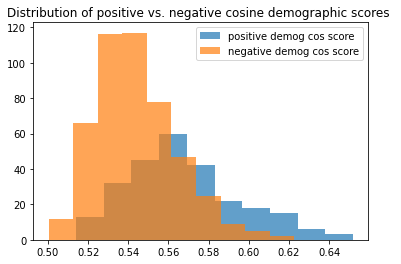

In [132]:
plt.hist(pos_demog['normalized_dem_cos'], label = 'positive demog cos score', alpha = 0.7)
plt.hist(neg_demog['normalized_dem_cos'], label = 'negative demog cos score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine demographic scores ')
plt.legend()
plt.show()

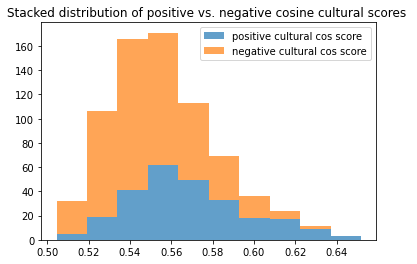

In [135]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural cos score','negative cultural cos score']

plt.hist([pos_demog['normalized_dem_cos'], neg_cult['normalized_dem_cos']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative cosine cultural scores ')
plt.legend()



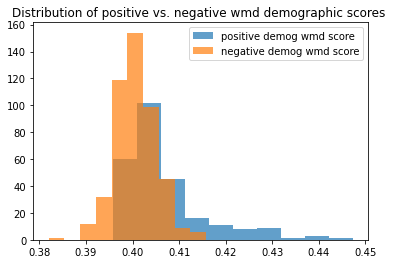

In [133]:
plt.hist(pos_demog['normalized_dem_wmd'], label = 'positive demog wmd score', alpha = 0.7)
plt.hist(neg_demog['normalized_dem_wmd'], label = 'negative demog wmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative wmd demographic scores ')
plt.legend()
plt.show()

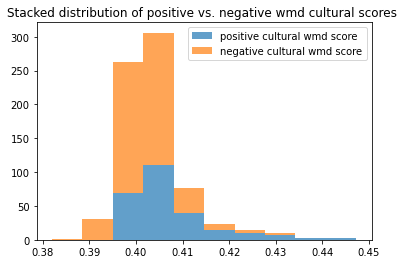

In [22]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural wmd score','negative cultural wmd score']

plt.hist([pos_demog['normalized_dem_wmd'], neg_cult['normalized_dem_wmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative wmd cultural scores ')
plt.legend()



## cultural

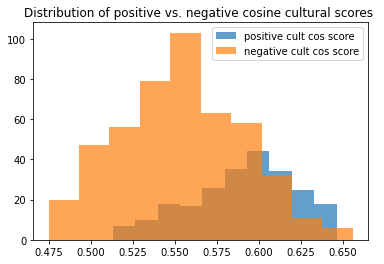

In [137]:
plt.hist(pos_cult['normalized_cult_cos'], label = 'positive cult cos score', alpha = 0.7)
plt.hist(neg_cult['normalized_cult_cos'], label = 'negative cult cos score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine cultural scores ')
plt.legend()
plt.show()

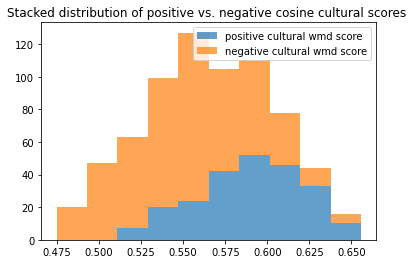

In [138]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural wmd score','negative cultural wmd score']

plt.hist([pos_cult['normalized_cult_cos'], neg_cult['normalized_cult_cos']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative cosine cultural scores ')
plt.legend()



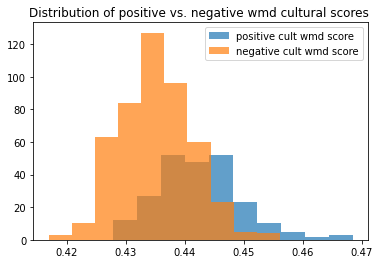

In [139]:
plt.hist(pos_cult['normalized_cult_wmd'], label = 'positive cult wmd score', alpha = 0.7)
plt.hist(neg_cult['normalized_cult_wmd'], label = 'negative cult wmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative wmd cultural scores ')
plt.legend()
plt.show()

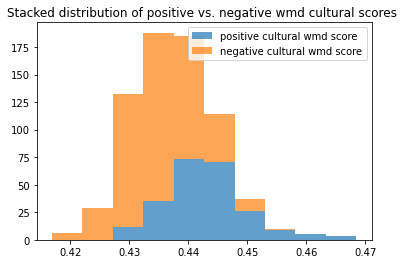

In [140]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural wmd score','negative cultural wmd score']

plt.hist([pos_cult['normalized_cult_wmd'], neg_cult['normalized_cult_wmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative wmd cultural scores ')
plt.legend()



## relational

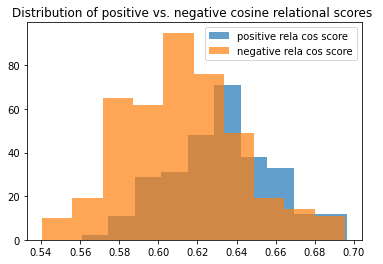

In [141]:
plt.hist(pos_rela['normalized_rela_cos'], label = 'positive rela cos score', alpha = 0.7)
plt.hist(neg_rela['normalized_rela_cos'], label = 'negative rela cos score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine relational scores ')
plt.legend()
plt.show()

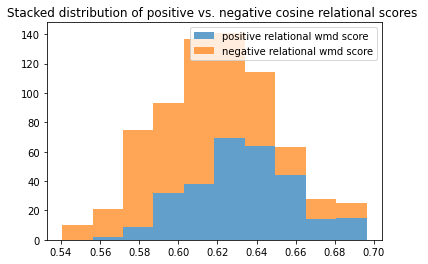

In [142]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive relational wmd score','negative relational wmd score']

plt.hist([pos_rela['normalized_rela_cos'], neg_rela['normalized_rela_cos']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative cosine relational scores ')
plt.legend()



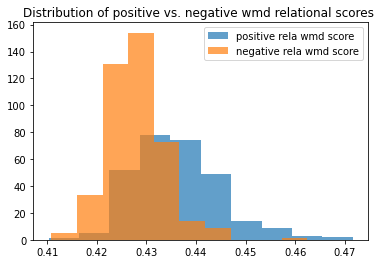

In [144]:
plt.hist(pos_rela['normalized_rela_wmd'], label = 'positive rela wmd score', alpha = 0.7)
plt.hist(neg_rela['normalized_rela_wmd'], label = 'negative rela wmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative wmd relational scores ')
plt.legend()
plt.show()

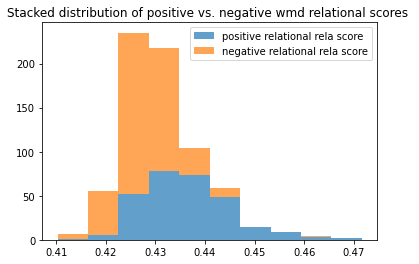

In [145]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive relational rela score','negative relational rela score']

plt.hist([pos_rela['normalized_rela_wmd'], neg_rela['normalized_rela_wmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative wmd relational scores ')
plt.legend()

